In [26]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/duke-data/Duke datset/val/images/Subject_08_01.npy
/kaggle/input/duke-data/Duke datset/val/images/Subject_08_05.npy
/kaggle/input/duke-data/Duke datset/val/images/Subject_08_04.npy
/kaggle/input/duke-data/Duke datset/val/images/Subject_08_03.npy
/kaggle/input/duke-data/Duke datset/val/images/Subject_07_02.npy
/kaggle/input/duke-data/Duke datset/val/images/Subject_07_06.npy
/kaggle/input/duke-data/Duke datset/val/images/Subject_07_08.npy
/kaggle/input/duke-data/Duke datset/val/images/Subject_08_08.npy
/kaggle/input/duke-data/Duke datset/val/images/Subject_07_03.npy
/kaggle/input/duke-data/Duke datset/val/images/Subject_07_09.npy
/kaggle/input/duke-data/Duke datset/val/images/Subject_08_06.npy
/kaggle/input/duke-data/Duke datset/val/images/Subject_07_05.npy
/kaggle/input/duke-data/Duke datset/val/images/Subject_08_02.npy
/kaggle/input/duke-data/Duke datset/val/images/Subject_08_09.npy
/kaggle/input/duke-data/Duke datset/val/images/Subject_08_07.npy
/kaggle/input/duke-data/D

In [27]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn.functional as F
import tqdm
import torchvision.transforms.functional as tf
import torch.nn as nn
from torchvision import transforms

from collections import OrderedDict
from torch.nn.modules.loss import _Loss
from typing import Callable


import torch.optim as optim
from torchmetrics.classification import MulticlassJaccardIndex

!pip install torchinfo

from torchinfo import summary


In [28]:

class FourierUnit(nn.Module):

    def __init__(self, in_channels, out_channels, groups=1, spatial_scale_mode='bilinear', fft_norm='ortho'):
        
        super(FourierUnit, self).__init__()

        self.groups = groups
        self.conv_layer = torch.nn.Conv2d(in_channels=in_channels * 2 ,
                                          out_channels=out_channels * 2,
                                          kernel_size=1, stride=1, padding=0, groups=self.groups, bias=False)
        self.bn = torch.nn.BatchNorm2d(out_channels * 2)
        self.relu = torch.nn.ReLU(inplace=True)

        self.spatial_scale_mode = spatial_scale_mode
        self.fft_norm = fft_norm

    def forward(self, x):
        batch = x.shape[0]

        fft_dim = (-2, -1)
        ffted = torch.fft.rfftn(x, dim=fft_dim, norm=self.fft_norm)
        ffted = torch.stack((ffted.real, ffted.imag), dim=-1)
        # (batch, c, h, w/2+1, 2)
        
        """clamp = False
        remove = False
        if clamp:
            ffted = torch.clamp(ffted, min=-10, max=10)
        if remove:
            fftedmin10 = torch.clamp(ffted, min=10)
            fftedmax10 = torch.clamp(ffted, max=-10)
            ffted = torch.where(ffted > 0, fftedmax10, fftedmin10)"""

        ffted = ffted.permute(0, 1, 4, 2, 3).contiguous()  # (batch, c, 2, h, w/2+1)
        ffted = ffted.view((batch, -1,) + ffted.size()[3:])

        ffted = self.conv_layer(ffted)  # (batch, c*2, h, w/2+1)
        ffted = self.relu(self.bn(ffted))

        ffted = ffted.view((batch, -1, 2,) + ffted.size()[2:]).permute(
            0, 1, 3, 4, 2).contiguous()  # (batch,c, h, w/2+1, 2)
        ffted = torch.complex(ffted[..., 0], ffted[..., 1])

        ifft_shape_slice =  x.shape[-2:]
        output = torch.fft.irfftn(ffted, s=ifft_shape_slice, dim=fft_dim, norm=self.fft_norm)

        return output


class SpectralTransform(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1, groups=1, enable_lfu=True):
        # bn_layer not used
        super(SpectralTransform, self).__init__()
        self.enable_lfu = enable_lfu
        if stride == 2:
            self.downsample = nn.AvgPool2d(kernel_size=(2, 2), stride=2)
        else:
            self.downsample = nn.Identity()

        self.stride = stride
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels //
                      2, kernel_size=1,groups=groups, bias=False),
            nn.BatchNorm2d(out_channels // 2),
            nn.ReLU(inplace=True)
        )
        self.fu = FourierUnit(
            out_channels // 2, out_channels // 2, groups)
        self.conv2 = torch.nn.Conv2d(
            out_channels // 2, out_channels, kernel_size=1,groups=groups, bias=False)

    def forward(self, x):

        x = self.downsample(x)
        x = self.conv1(x)
        output = self.fu(x)

        if self.enable_lfu:
            n, c, h, w = x.shape
            split_no = 2
            split_s = h // split_no
            xs = torch.cat(torch.split( x[:, :c // 4], split_s, dim=-2), dim=1).contiguous()    #(n, c // 4 * split_no, split_s, w)
            xs = torch.cat(torch.split(xs, split_s, dim=-1),dim=1).contiguous()     #(n, c // 4 * split_no^2, split_s, split_s)
            xs = self.fu(xs)
            xs = xs.repeat(1, 1, split_no, split_no).contiguous()
        else:
            xs = 0

        output = self.conv2(x + output + xs)

        return output


class FFC(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size,
                 ratio_gin, ratio_gout, stride=1, padding=0,
                 dilation=1,groups=1, bias=False, enable_lfu=True,
                 padding_type='reflect'):
        super(FFC, self).__init__()

        self.stride = stride

        in_cg = int(in_channels * ratio_gin)
        in_cl = in_channels - in_cg
        out_cg = int(out_channels * ratio_gout)
        out_cl = out_channels - out_cg

        self.ratio_gin = ratio_gin
        self.ratio_gout = ratio_gout
        self.global_in_num = in_cg

        module = nn.Identity if in_cl == 0 or out_cl == 0 else nn.Conv2d
        self.convl2l = module(in_cl, out_cl, kernel_size,
                              stride, padding, dilation, groups, bias, padding_mode=padding_type)
        module = nn.Identity if in_cl == 0 or out_cg == 0 else nn.Conv2d
        self.convl2g = module(in_cl, out_cg, kernel_size,
                              stride, padding, dilation, groups, bias, padding_mode=padding_type)
        module = nn.Identity if in_cg == 0 or out_cl == 0 else nn.Conv2d
        self.convg2l = module(in_cg, out_cl, kernel_size,
                              stride, padding, dilation, groups, bias, padding_mode=padding_type)
        module = nn.Identity if in_cg == 0 or out_cg == 0 else SpectralTransform
        self.convg2g = module(
            in_cg, out_cg, stride, 1 if groups == 1 else groups // 2, enable_lfu)

        module = nn.Identity if in_cg == 0 or out_cl == 0 else nn.Conv2d

    def forward(self, x):
        x_l, x_g = x if isinstance(x, tuple) else (x, torch.zeros_like(x))

        out_xl, out_xg = 0, 0

        g2l_gate, l2g_gate = 1, 1

        if self.ratio_gout != 1:
            out_xl = self.convl2l(x_l) + self.convg2l(x_g) * g2l_gate
            
        if self.ratio_gout != 0:
            out_xg = self.convl2g(x_l) * l2g_gate + self.convg2g(x_g)
            
        return out_xl, out_xg



class FFC_BN_ACT(nn.Module):

    def __init__(self, in_channels, out_channels,kernel_size, ratio_gin, ratio_gout,
                 stride=1, padding=0, dilation=1,groups=1, bias=False,
                 norm_layer=nn.BatchNorm2d, activation_layer=nn.Identity,padding_type='reflect',enable_lfu=True):
        
        super(FFC_BN_ACT, self).__init__()
        self.ffc = FFC(in_channels, out_channels, kernel_size,
                       ratio_gin, ratio_gout, stride, padding, dilation,
                       groups, bias, enable_lfu, padding_type=padding_type)
        lnorm = nn.Identity if ratio_gout == 1 else norm_layer
        gnorm = nn.Identity if ratio_gout == 0 else norm_layer
        global_channels = int(out_channels * ratio_gout)
        self.bn_l = lnorm(out_channels - global_channels)
        self.bn_g = gnorm(global_channels)

        lact = nn.Identity if ratio_gout == 1 else activation_layer
        gact = nn.Identity if ratio_gout == 0 else activation_layer
        self.act_l = lact(inplace=True)
        self.act_g = gact(inplace=True)

    def forward(self, x):
        x_l, x_g = self.ffc(x)
        x_l = self.act_l(self.bn_l(x_l))
        x_g = self.act_g(self.bn_g(x_g))
        return x_l, x_g
        

class ConcatTupleLayer(nn.Module):
    def forward(self, x):
        assert isinstance(x, tuple)
        x_l, x_g = x
        assert torch.is_tensor(x_l) or torch.is_tensor(x_g)
        if not torch.is_tensor(x_g):
            return x_l
        return torch.cat(x, dim=1)


In [29]:
class DiceLoss(_Loss):
    def forward(self, output, target, weights=None):
        
        """output : NxCxHxW Variable
        target :  NxHxW LongTensor
        weights : C FloatTensor
        ignore_index : int index to ignore from loss"""
            
        eps = 0.0001

        output = output.exp()
        encoded_target = output.detach() * 0
        
        encoded_target.scatter_(1, target.unsqueeze(1), 1)

        if weights is None:
            weights = 1

        intersection = output * encoded_target
        numerator = 2 * intersection.sum(0).sum(1).sum(1) + eps
        denominator = output + encoded_target

        denominator = denominator.sum(0).sum(1).sum(1) + eps
        loss_per_channel = weights * (1 - (numerator / denominator))

        return loss_per_channel.sum() / output.size(1)


class CrossEntropyLoss2d(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(CrossEntropyLoss2d, self).__init__()
        self.nll_loss = nn.CrossEntropyLoss(weight, size_average)

    def forward(self, inputs, targets):
        return self.nll_loss(inputs, targets)


class CombinedLoss(nn.Module):
    def __init__(self):
        super(CombinedLoss, self).__init__()
        self.cross_entropy_loss = CrossEntropyLoss2d()
        self.dice_loss = DiceLoss()

    def forward(self, input, target, weight=1, device="cuda"):
        target = target.type(torch.LongTensor).to(device)
        input_soft = F.softmax(input,dim=1)
        y2 = torch.mean(self.dice_loss(input_soft, target))
        y1 = torch.mean(torch.mul(self.cross_entropy_loss.forward(input, target), weight))
        y = y1 + y2
        return y
        
def per_class_dice(y_pred, y_true, num_class):
    avg_dice = 0
    y_pred = y_pred.data.squeeze() 
    y_true = y_true.data.squeeze() 
    dice_all = np.zeros(num_class)
    for i in range(num_class):
        GT = y_true[:,:,i].view(-1)
        Pred = y_pred[:,:,i].view(-1)
        #print(GT.shape, Pred.shape)
        inter = (GT * Pred).sum() 
        union = GT.sum()  + Pred.sum()  + 0.0001
        t =  (2 *inter + 0.0001) / union
        avg_dice = avg_dice + (t / num_class)
        dice_all[i] = t
    return avg_dice, dice_all

In [30]:

def get_files(path, ext):
    return [f for f in os.listdir(path) if os.path.isfile(os.path.join(path,f)) and f.endswith(ext)]


def get_data(data_path, img_size, batch_size, val_batch_size=1):
    train_dataset_path = os.path.join(data_path, "train")
    val_dataset_path = os.path.join(data_path, "val")
    test_dataset_path = os.path.join(data_path, "test")

    size_transform = transforms.Compose([transforms.Resize((img_size, img_size))])


    img_transform = None

    train_dataset = DatasetOct(train_dataset_path, size_transform=size_transform, normalized=True, image_transform=img_transform)
    val_dataset = DatasetOct(val_dataset_path, size_transform=size_transform, normalized=True)
    test_dataset = DatasetOct(test_dataset_path, size_transform=size_transform, normalized=True)

    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False)
    testloader = DataLoader(test_dataset, batch_size=val_batch_size, shuffle=False)

    return trainloader, valloader, testloader, train_dataset, val_dataset, test_dataset


class TransformStandardization(object):
    """
    Standardizaton / z-score: (x-mean)/std
    """
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, image):
        return (image - self.mean) / self.std

    def __repr__(self):
        return self.__class__.__name__ + f": mean {self.mean}, std {self.std}"


class TransformOCTMaskAdjustment(object):
    """
    Adjust OCT 2015 Mask
    from: classes [0,1,2,3,4,5,6,7,8,9], where 9 is fluid, 0 is empty space above and 8 empty space below
    to: class 0: not class, classes 1-7: are retinal layers, class 8: fluid
    """
    def __call__(self, mask):
        mask[mask == 8] = 0
        mask[mask == 9] = 8
        return mask


class DatasetOct(Dataset):
    """
    Map style dataset object for oct 2015 data
    - expects .npy files
    - assumes sliced images, masks - produced by our project: dataloading/preprocessing.py
        (valid dims of images,masks and encoding: pixel label e [0..9], for every pixel)

    Parameters:
        dataset_path: path to the dataset path/{images,masks}
        size_transform: deterministic transformation for resizing applied to image and mask separately
        joint_transform: random transformations applied to image and mask jointly after size_transform
        image_transform: transformation applied only to the image and after joint_transform
    _getitem__(): returns image and corresponding mask
    """

    def __init__(self, dataset_path: str, joint_transform: Callable = None, size_transform: Callable = None,
                 image_transform: Callable = None, normalized=True) -> None:
        self.dataset_path = dataset_path
        self.input_path = os.path.join(dataset_path, 'images')
        self.output_path = os.path.join(dataset_path, 'masks')
        self.images_list = get_files(self.input_path, ".npy")

        # size transform
        self.size_transform = size_transform

        self.joint_transform = joint_transform

        self.mask_adjust = TransformOCTMaskAdjustment()

        self.image_transform = image_transform

        self.normalized = normalized
        # gray scale oct 2015: calculated with full tensor in memory {'mean': tensor([46.3758]), 'std': tensor([53.9434])}
        # calculated with batched method {'mean': tensor([46.3756]), 'std': tensor([53.9204])}
        self.normalize = TransformStandardization((46.3758),
                                                  (53.9434))  # torchvision.transforms.Normalize((46.3758), (53.9434))

    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        image_filename = self.images_list[idx]

        img = np.load(os.path.join(self.input_path, image_filename))
        mask = np.load(os.path.join(self.output_path, image_filename))

        # img_size 128 works - general transforms require (N,C,H,W) dims
        img = img.squeeze()
        mask = mask.squeeze()

        img = torch.Tensor(img).reshape(1, 1, *img.shape)
        mask = torch.Tensor(mask).reshape(1, 1, *mask.shape).int()

        # adjust mask classes
        mask = self.mask_adjust(mask)

        # note for some reason some masks differ in size from the actual image (dims)
        if self.size_transform:
            img = self.size_transform(img)
            mask = self.size_transform(mask)

        # normalize after size_transform
        if self.normalized:
            img = self.normalize(img)

        if self.joint_transform:
            img, mask = self.joint_transform([img, mask])

        #img = img.reshape(1, img.shape[2], img.shape[3])
        if self.image_transform:
            img = self.image_transform(img)

        #img = img.reshape(1, *img.shape)

        # set image dim to (C,H,W)
        img = img.squeeze()
        img = img.reshape(1, *img.shape)
        # set mask dim to (H,W)  where value at (h,w) maps to class of corresponding pixel
        mask = mask.squeeze(dim=1).long()

        return img, mask



def colored_text(st):
    return '\033[91m' + st + '\033[0m'


def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)



In [31]:

class YNet_general(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32, ratio_in=0.5, ffc=True, skip_ffc=False,
                 cat_merge=True):
        super(YNet_general, self).__init__()

        self.ffc = ffc
        self.skip_ffc = skip_ffc
        self.ratio_in = ratio_in
        self.cat_merge = cat_merge

        features = init_features
        
        self.encoder1 = YNet_general._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = YNet_general._block(features, features * 2, name="enc2") 
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = YNet_general._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = YNet_general._block(features * 4, features * 4, name="enc4")  
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        
        
        self.encoder1_f = FFC_BN_ACT(in_channels, features, kernel_size=1, ratio_gin=0, ratio_gout=ratio_in)
        self.pool1_f = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2_f = FFC_BN_ACT(features, features * 2, kernel_size=1, ratio_gin=ratio_in,
                                    ratio_gout=ratio_in)  
        self.pool2_f = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3_f = FFC_BN_ACT(features * 2, features * 4, kernel_size=1, ratio_gin=ratio_in,
                                    ratio_gout=ratio_in)
        self.pool3_f = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4_f = FFC_BN_ACT(features * 4, features * 4, kernel_size=1, ratio_gin=ratio_in,
                                    ratio_gout=ratio_in)  
        self.pool4_f = nn.MaxPool2d(kernel_size=2, stride=2)

        

        self.bottleneck = YNet_general._block(features * 8, features * 16, name="bottleneck")  

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2  
        )
        self.decoder4 = YNet_general._block((features * 6) * 2, features * 8, name="dec4")  
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = YNet_general._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = YNet_general._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = YNet_general._block(features * 2, features, name="dec1")  

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )
        self.softmax = nn.Softmax2d()
        self.catLayer = ConcatTupleLayer()


    def forward(self, x):
        
        #[10, 9, 224, 224] 
        
        enc1 = self.encoder1(x)    #[10, 32, 224, 224] 
                                    
        enc2 = self.encoder2(self.pool1(enc1))  #[10, 32, 112, 112] 
                                                #[10, 64, 112, 112]

        enc3 = self.encoder3(self.pool2(enc2))  #[10, 64, 56, 56]  
                                                #[10, 128, 56, 56]

        enc4 = self.encoder4(self.pool3(enc3))  #[10, 128, 28, 28] 
                                                #[10, 128, 28, 28] 
                                                
        enc4_2 = self.pool4(enc4)       #[10, 128, 14, 14] 

        
        ############ Spectral Encoder #############
        
        enc1_f = self.encoder1_f(x)     #[10, 16, 224, 224]
        
        enc1_l, enc1_g = enc1_f
        if self.ratio_in == 0:
            enc2_f = self.encoder2_f((self.pool1_f(enc1_l), enc1_g))
        elif self.ratio_in == 1:
            enc2_f = self.encoder2_f((enc1_l, self.pool1_f(enc1_g)))
        else:
            enc2_f = self.encoder2_f((self.pool1_f(enc1_l), self.pool1_f(enc1_g)))

        enc2_l, enc2_g = enc2_f      #[10, 32, 112, 112]
        if self.ratio_in == 0:
            enc3_f = self.encoder3_f((self.pool2_f(enc2_l), enc2_g))
        elif self.ratio_in == 1:
            enc3_f = self.encoder3_f((enc2_l, self.pool2_f(enc2_g)))
        else:
            enc3_f = self.encoder3_f((self.pool2_f(enc2_l), self.pool2_f(enc2_g)))

        enc3_l, enc3_g = enc3_f     #[10, 64, 56, 56]  
        if self.ratio_in == 0:
            enc4_f = self.encoder4_f((self.pool3_f(enc3_l), enc3_g))
        elif self.ratio_in == 1:
            enc4_f = self.encoder4_f((enc3_l, self.pool3_f(enc3_g)))
        else:
            enc4_f = self.encoder4_f((self.pool3_f(enc3_l), self.pool3_f(enc3_g)))

        enc4_l, enc4_g = enc4_f     #[10, 64, 28, 28]
        if self.ratio_in == 0:
            enc4_f2 = self.pool1_f(enc4_l)
        elif self.ratio_in == 1:
            enc4_f2 = self.pool1_f(enc4_g)
        else:
            enc4_f2 = self.catLayer((self.pool4_f(enc4_l), self.pool4_f(enc4_g)))
        #[10, 128, 14, 14] 
        

        
        a = torch.zeros_like(enc4_2)
        b = torch.zeros_like(enc4_f2)

        enc4_2 = enc4_2.view(torch.numel(enc4_2), 1)     # flatten to shape (num_elements, 1)
        enc4_f2 = enc4_f2.view(torch.numel(enc4_f2), 1)

        bottleneck = torch.cat((enc4_2, enc4_f2), 1)     # shape of (num_elements, 2)
        bottleneck = bottleneck.view_as(torch.cat((a, b), 1))

        
        #[10, 256, 14, 14] 
        bottleneck = self.bottleneck(bottleneck)        #[10, 512, 14, 14] 

        dec4 = self.upconv4(bottleneck)     #[10, 256, 28, 28]

        
        dec4 = torch.cat((dec4, enc4), dim=1)   #[10, 384, 28, 28]
        dec4 = self.decoder4(dec4)      #[10, 256, 28, 28]
        dec3 = self.upconv3(dec4)       #[10, 128, 56, 56]
        dec3 = torch.cat((dec3, enc3), dim=1)   #[10, 256, 56, 56]
        dec3 = self.decoder3(dec3)      #[10, 128, 56, 56]
        dec2 = self.upconv2(dec3)       #[10, 64, 112, 112] 
        dec2 = torch.cat((dec2, enc2), dim=1)       #[10, 128, 112, 112] 
        dec2 = self.decoder2(dec2)      #[10, 64, 112, 112] 
        dec1 = self.upconv1(dec2)       #[10, 32, 224, 224] 
        dec1 = torch.cat((dec1, enc1), dim=1)       #[10, 64, 224, 224] 

        dec1 = self.decoder1(dec1)      #[10, 32, 224, 224] 

        return self.softmax(self.conv(dec1))        #[10, 9, 224, 224] 

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )


In [33]:
def eval(val_loader, criterion, model, n_classes, dice_s=True, device="cuda", im_save=False):
    model.eval()
    loss = 0    
    counter = 0
    dice = 0

    dice_all = np.zeros(n_classes)

    for img, label in tqdm.tqdm(val_loader):
        img = img.to(device)
        label = label.to(device)
        label_oh = torch.nn.functional.one_hot(label, num_classes=n_classes)

        pred = model(img)
        max_val, idx = torch.max(pred, 1)
        pred_oh = torch.nn.functional.one_hot(idx, num_classes=n_classes)

        if dice_s:
            d1, d2 = per_class_dice(pred_oh, label_oh, n_classes)
            dice += d1
            dice_all += d2

        loss += criterion(pred, label.squeeze(1), device=device).item()

        counter += 1

    loss = loss / counter
    dice = dice / counter
    dice_all = dice_all / counter
    print("Validation loss: ", loss, " Mean Dice: ", dice.item(), "Dice All:", dice_all)
    return dice

In [ ]:

# Directly defined variables
device = "cuda"
n_classes = 9
in_channels =1
model_name = "y_net_gen_ffc"
learning_rate = 5e-4
g_ratio = 0.5
image_dir = "/kaggle/input/duke-data/Duke datset"
num_iterations = 100
image_size = 224
batch_size = 10
weight_decay = 1e-4
seed = 7

# Set the random seed for reproducibility
set_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model, optimizer, and loss functions
model= YNet_general(in_channels, n_classes, ffc=True, ratio_in=g_ratio)
#model = UNet(in_channels, n_classes)



model = model.to(device)

print(summary(model, input_size=(batch_size, in_channels, image_size, image_size)))

model.train()

optimizer = torch.optim.Adam(list(model.parameters()), lr=learning_rate, weight_decay=weight_decay)
criterion_seg = CombinedLoss()

save_name = model_name + ".pt"

# Load data
train_loader, val_loader, test_loader, _, _, _ = get_data(image_dir, image_size, batch_size)

max_dice = 0
best_test_dice = 0
best_iter = 0

# Training loop
for t in range(num_iterations):
    for img, label in tqdm.tqdm(train_loader):
        img = img.to(device)
        label = label.to(device)
        label_oh = torch.nn.functional.one_hot(label, num_classes=n_classes).squeeze()

        pred = model(img)
        max_val, idx = torch.max(pred, 1)
        pred_oh = torch.nn.functional.one_hot(idx, num_classes=n_classes)
        pred_oh = pred_oh.permute(0, 3, 1, 2)
        label_oh = label_oh.permute(0, 3, 1, 2)
        loss = criterion_seg(pred, label.squeeze(1), device=device) 

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if t % 2 == 0:
        print(loss.item())

    if t % 10 == 0 or t > 45:
        print("Epoch", t, "/", num_iterations)
        print("Validation")
        dice = eval(val_loader, criterion_seg, model, dice_s=True, n_classes=n_classes)
        print("Expert 1 - Test")
        dice_test = eval(test_loader, criterion_seg, model, n_classes=n_classes)

        if dice > max_dice:
            max_dice = dice
            best_iter = t
            best_test_dice = dice_test
            print(colored_text("Updating model, epoch: "), t)

            torch.save(model.state_dict(), save_name)
        model.train()

print("Best iteration: ", best_iter, "Best val dice: ", max_dice, "Best test dice: ", best_test_dice)


In [35]:
# Initialize the model architecture
best_model = YNet_general(in_channels, n_classes, ffc=True, ratio_in=g_ratio).to(device)
#best_model = UNet(in_channels, n_classes)
# Load the saved weights
best_model.load_state_dict(torch.load(save_name))

# Set the model to evaluation mode
best_model.eval()

print("Best model loaded successfully.")


Best model loaded successfully.


/tmp/ipykernel_23/1117213423.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(save_name))


In [36]:
dice_test = eval(test_loader, criterion_seg, best_model, n_classes=n_classes)

100%|██████████| 22/22 [00:00<00:00, 40.82it/s]

Validation loss:  2.2584997849030928  Mean Dice:  0.8299409747123718 Dice All: [0.99714822 0.83844195 0.88405385 0.73344561 0.71037074 0.88419394
 0.85671764 0.77144686 0.79365037]


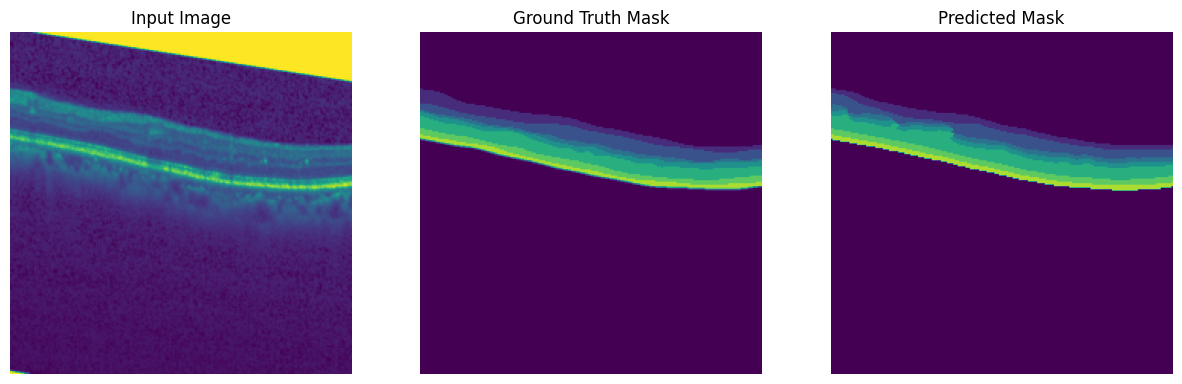

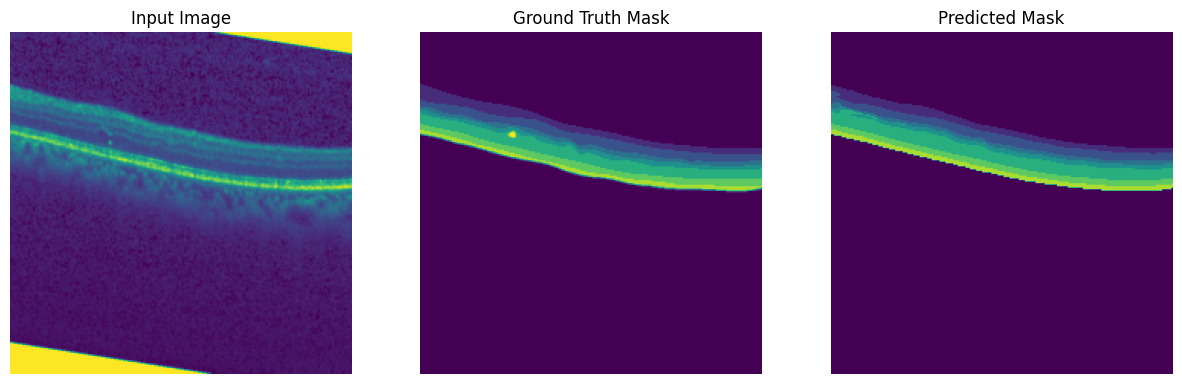

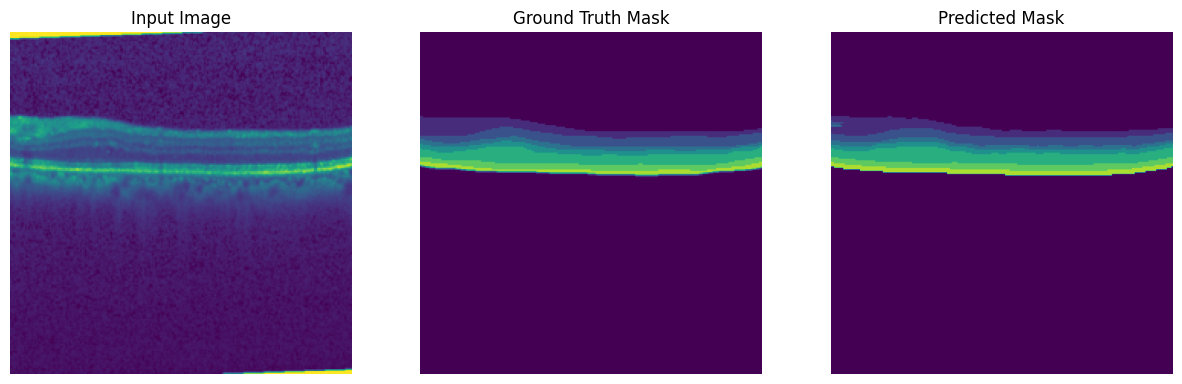

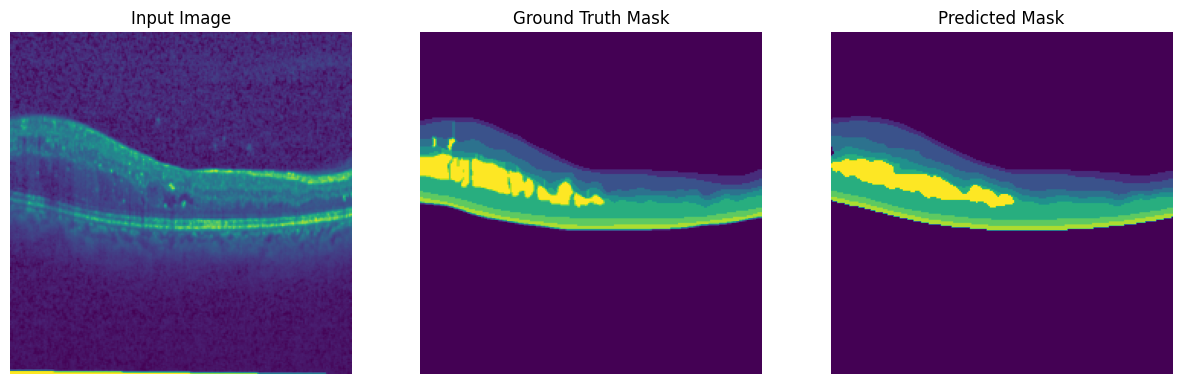

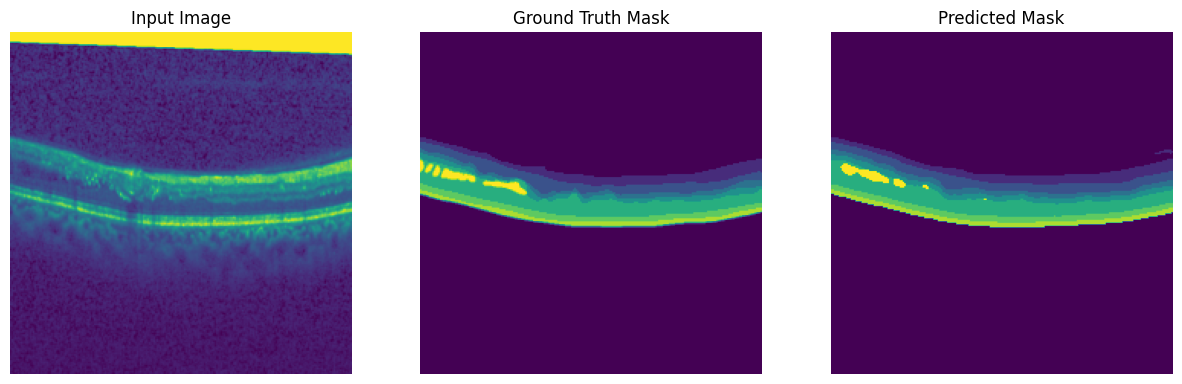

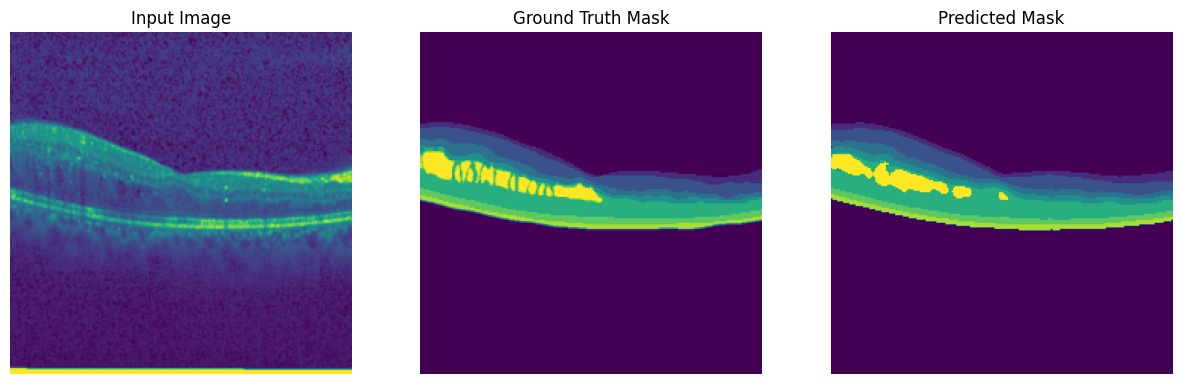

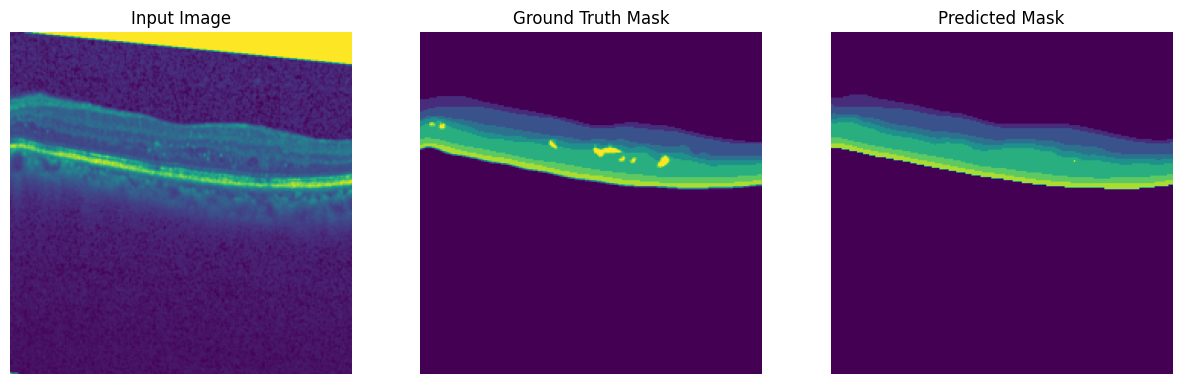

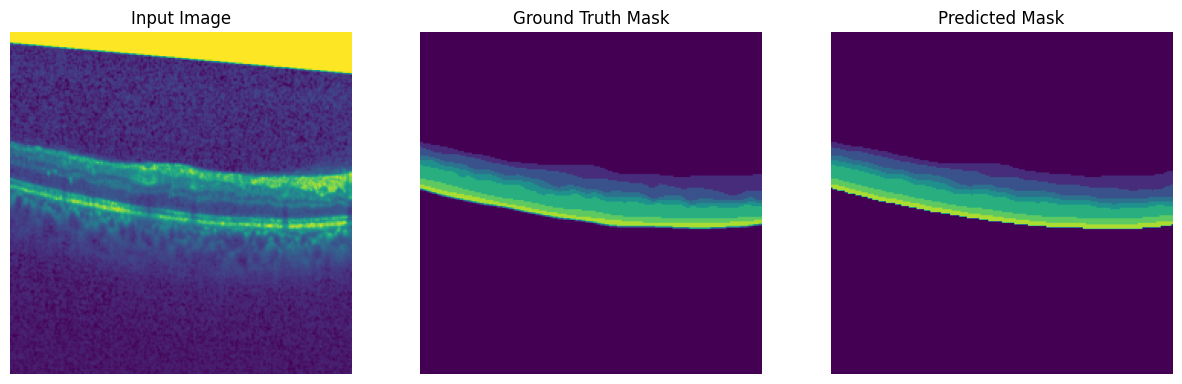

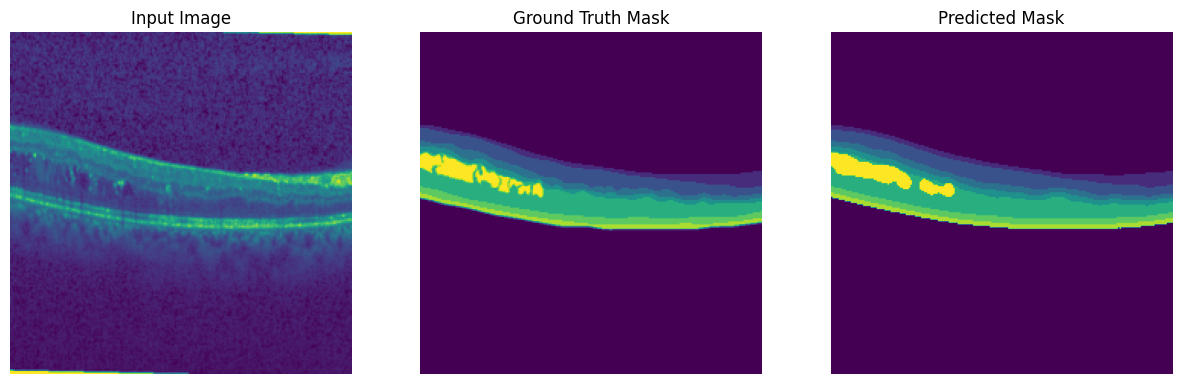

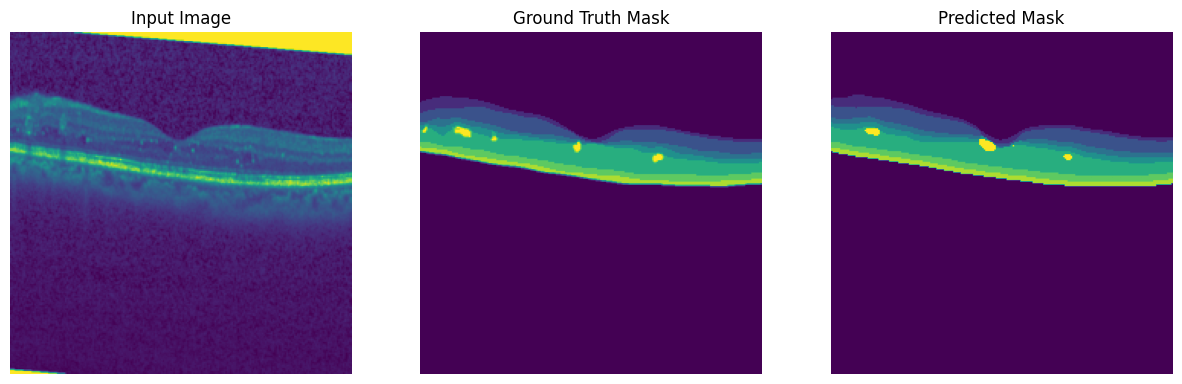

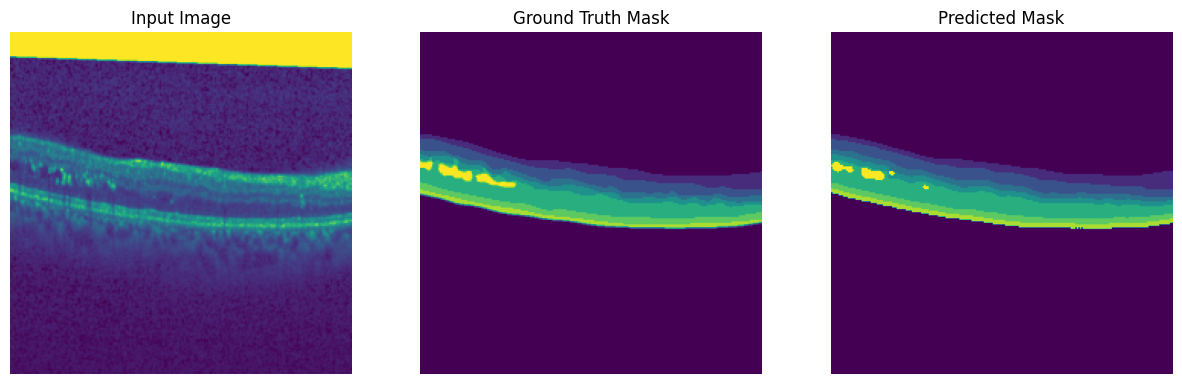

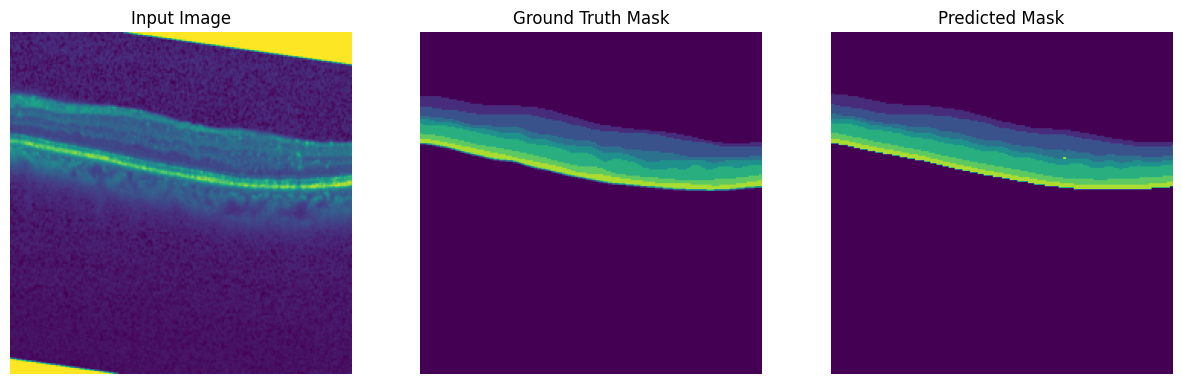

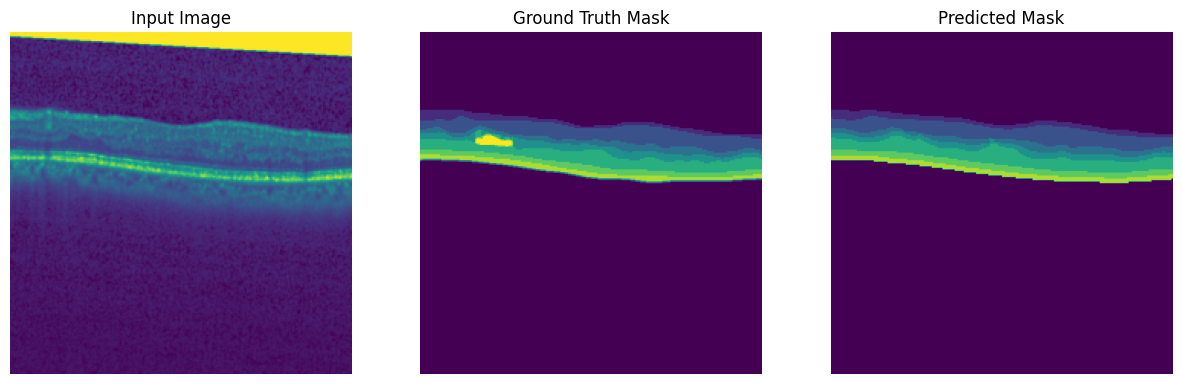

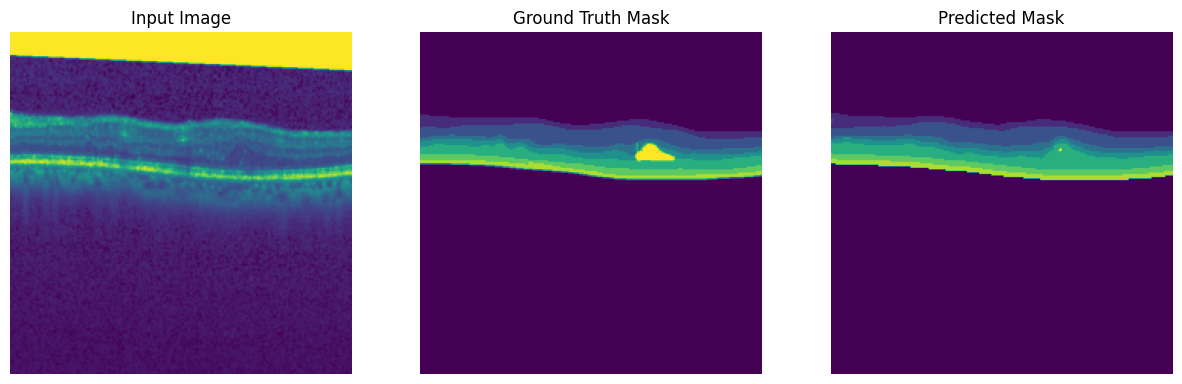

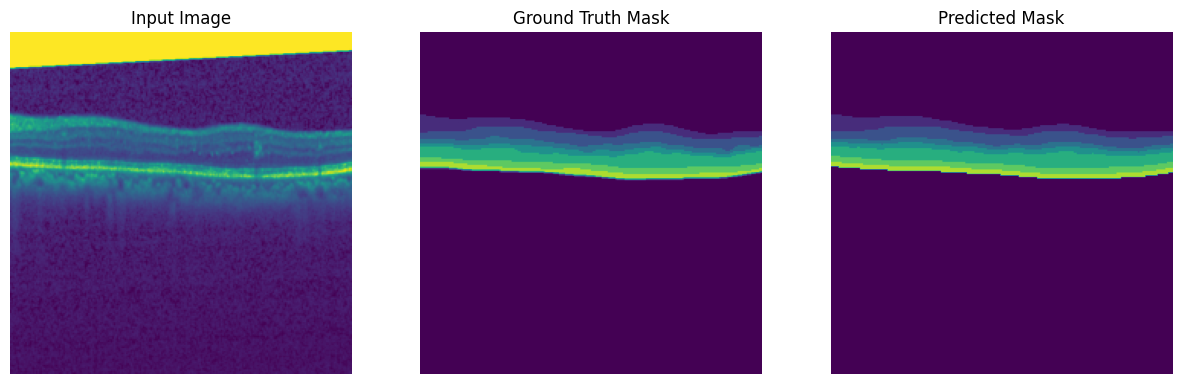

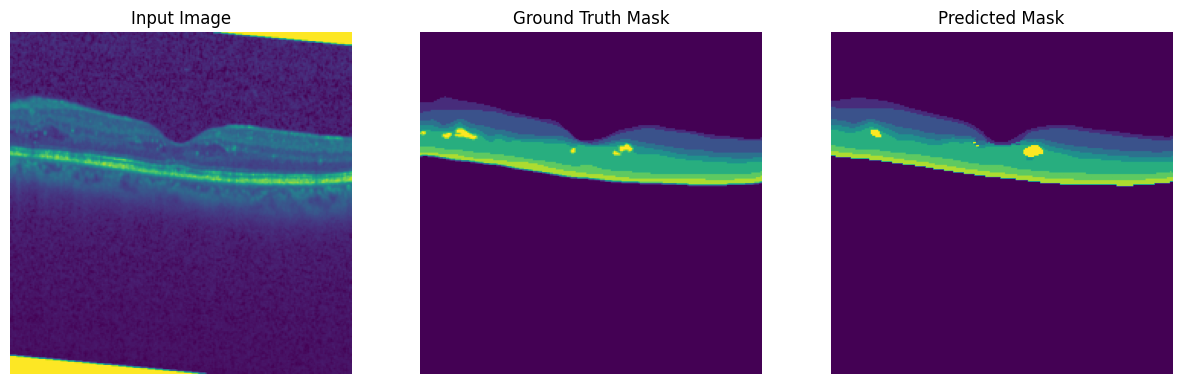

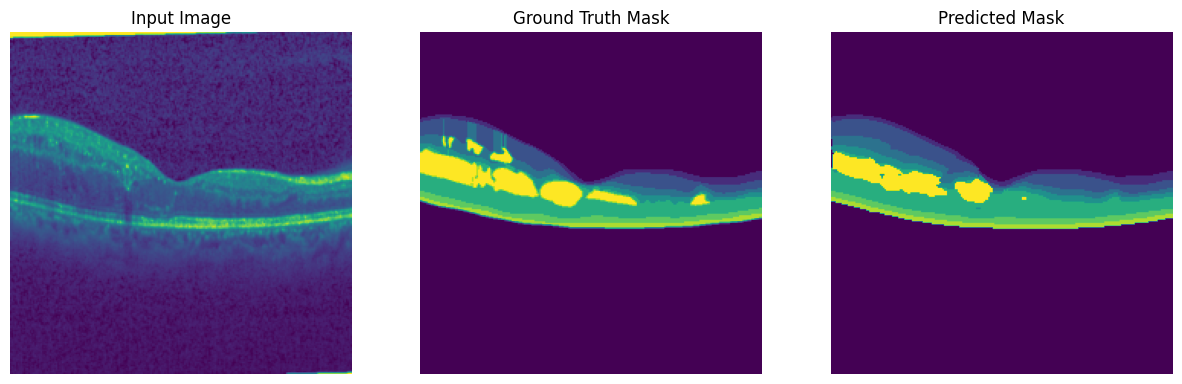

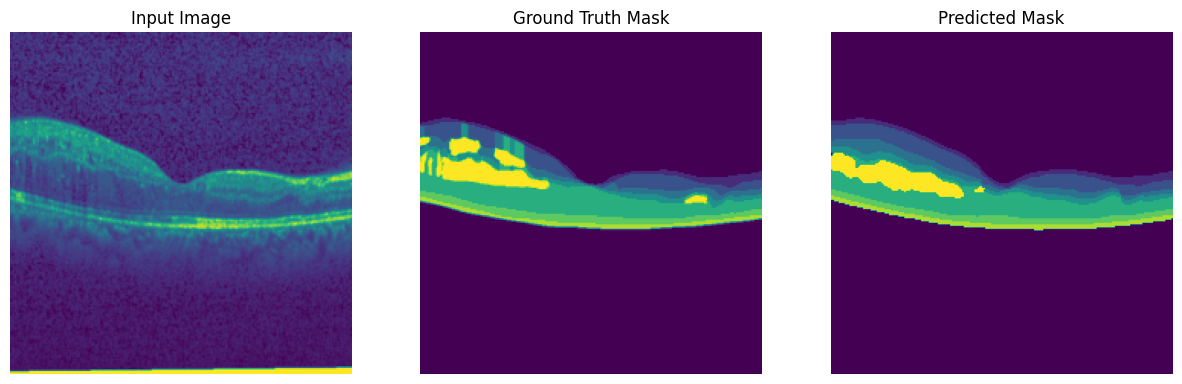

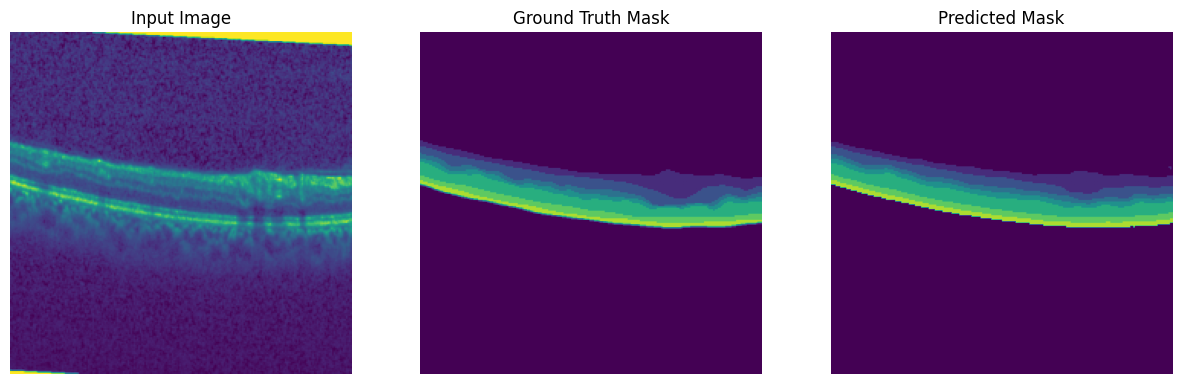

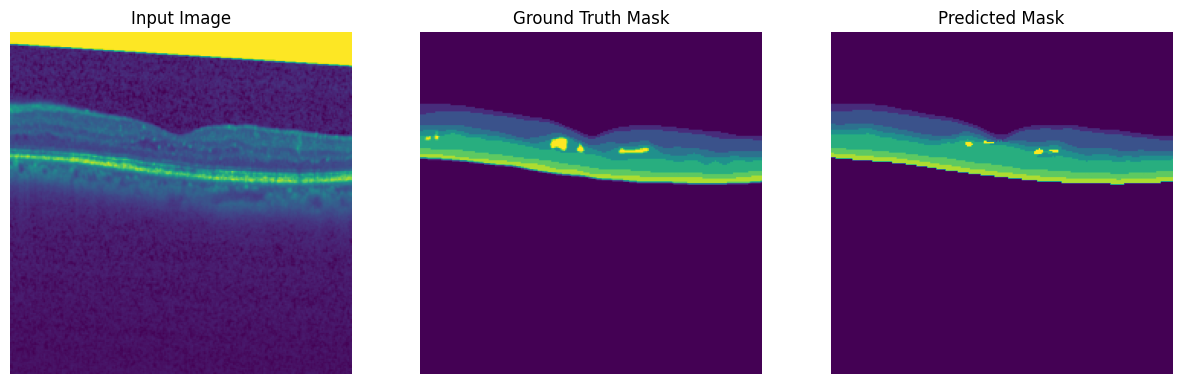

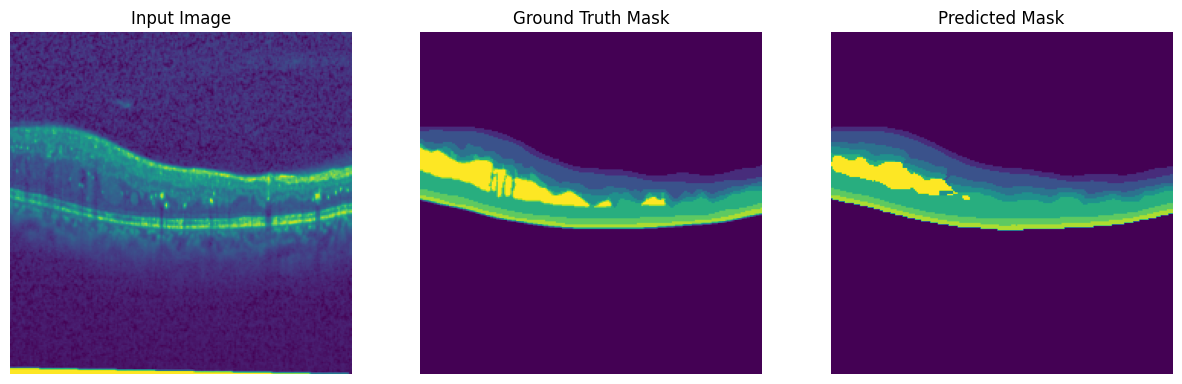

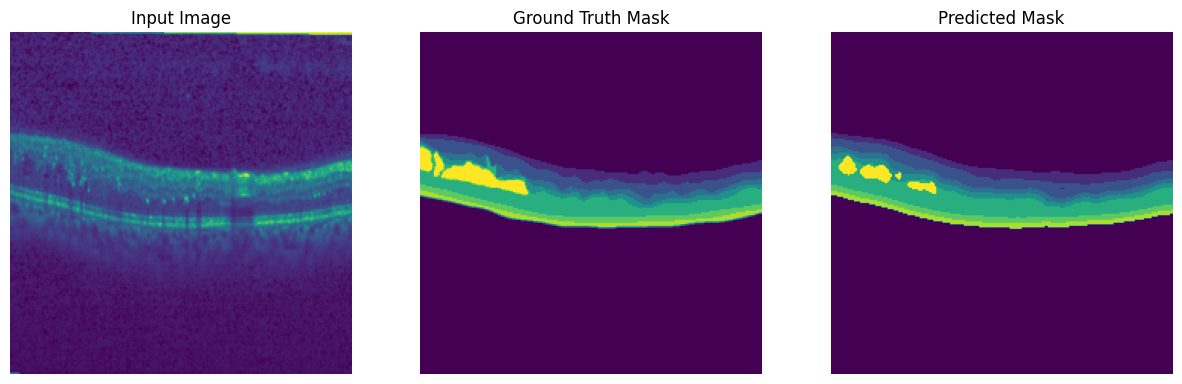

In [37]:
import matplotlib.pyplot as plt

def visualize_test_results(test_loader, model, n_classes, device="cuda"):
    """
    Visualizes test results: input image, ground truth mask, and predicted mask.

    Args:
        test_loader (DataLoader): DataLoader for the test dataset.
        model (torch.nn.Module): Trained model for predictions.
        n_classes (int): Number of classes in the segmentation task.
        device (str): Device to use for computation ("cuda" or "cpu").
    """
    model.eval()
    model.to(device)

    for img, label in test_loader:
        img, label = img.to(device), label.to(device)

        # Get prediction from the model
        with torch.no_grad():
            pred = model(img)
            pred = torch.argmax(pred, dim=1)

        # Convert tensors to numpy arrays for visualization
        img_np = img[0].squeeze().cpu().numpy()  # Convert to 2D for grayscale image
        label_np = label[0].squeeze().cpu().numpy()  # Ground truth mask
        pred_np = pred[0].cpu().numpy()  # Predicted mask

        # Plot the results
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))

        # Input Image
        ax[0].imshow(img_np)
        ax[0].set_title("Input Image")
        ax[0].axis("off")

        # Ground Truth Mask
        ax[1].imshow(label_np, vmin=0, vmax=n_classes - 1)
        ax[1].set_title("Ground Truth Mask")
        ax[1].axis("off")

        # Predicted Mask
        ax[2].imshow(pred_np, vmin=0, vmax=n_classes - 1)
        ax[2].set_title("Predicted Mask")
        ax[2].axis("off")

        plt.show()

        # Only show one batch for simplicity
       



visualize_test_results(test_loader, best_model, n_classes=9, device=device)
